In [1]:
!python -V

Python 3.8.10


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
print("1. How many columns are there?")
print(df.shape[1])

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
print("2. What's the standard deviation of the trips duration in January?")
print(round(df.duration.std(), 2))

size_before = df.shape[0]
df = df[(df.duration >= 1) & (df.duration <= 60)]
print("3. What fraction of the records left after dropping the outliers?")
print(str(round(df.shape[0] / size_before * 100))+"%")

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

1. How many columns are there?
19
2. What's the standard deviation of the trips duration in January?
42.59
3. What fraction of the records left after dropping the outliers?
98%


In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
print("What's the dimensionality of feature  matrix (number of columns)?")
print(X_train.shape[1] - 1)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print("5. What's the RMSE on train?")
mean_squared_error(y_train, y_pred, squared=False)

What's the dimensionality of feature  matrix (number of columns)?
515
5. What's the RMSE on train?


7.658559076531841

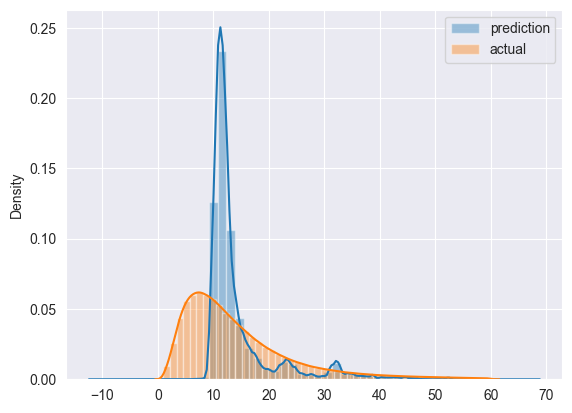

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [11]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [12]:
len(df_train), len(df_val)

(3009173, 2855951)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO']  #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.244535975468218

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

print("6. What's the RMSE on validation?")
mean_squared_error(y_val, y_pred, squared=False)

6. What's the RMSE on validation?


9.395699095576239